# Imports et setup technique

In [116]:
import pandas as pd
idx = pd.IndexSlice
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import seaborn as sns
from bokeh.io import output_notebook, show
output_notebook()
from bokeh.plotting import figure
from bokeh.models.annotations import BoxAnnotation

Loading BokehJS ...

# Chargement des données

## Données de base client

In [2]:
cltfields = {
             'client': 'object',
             'V': 'object',
             'groupecompte': 'object',
             'nom': 'object',
             'postalcode': 'object',
             'seg1': 'object',
             'seg2': 'object',
             'seg3': 'object',
             'seg4': 'object',
             'cat': 'object',
             'sscat': 'object',
#              'saiso': 'bool',
             'surcat': 'object',
#              'ecom': 'bool', 
             'sectact': 'object',
             'canal': 'object', 
             'orgacom': 'object', 
             'grpclt1': 'object',
             'grpclt2': 'object',
             'grpclt3': 'object',
             'grpclt4': 'object',
             'grpclt5': 'object',
             'agence': 'object', 
             'condexp': 'object', 
             'pricetype': 'object', 
             'relationtype': 'object',
             'pilcom': 'object',
             'hier4': 'object',
             'hier3': 'object',
             'hier2': 'object',
             'hier1': 'object',
            }

clt_fields2 = {
             'client': 'object',
             'V': 'category',
             'groupecompte': 'category',
             'nom': 'object',
             'postalcode': 'category',
             'seg1': 'category',
             'seg2': 'category',
             'seg3': 'category',
             'seg4': 'category',
             'cat': 'category',
             'sscat': 'category',
#              'saiso': 'bool',
             'surcat': 'category',
#              'ecom': 'bool', 
             'sectact': 'category',
             'canal': 'category', 
             'orgacom': 'category', 
             'grpclt1': 'category',
             'grpclt2': 'category',
             'grpclt3': 'category',
             'grpclt4': 'category',
             'grpclt5': 'category',
             'agence': 'category', 
             'condexp': 'category', 
             'pricetype': 'category', 
             'relationtype': 'category',
             'pilcom': 'category',
             'hier4': 'object',
             'hier3': 'object',
             'hier2': 'object',
             'hier1': 'object',
            }

filenames = [
    'ref_clt.csv',
    'ref_clt2.csv',
]
paths = [Path('..') / 'data' / filename for filename in filenames]

df_clts = [
    pd.read_csv(path,
                sep=';',
                encoding='latin1', 
                dtype=cltfields,
                converters={'saiso': lambda x: True if x == 'YES' else False, 
                            'ecom': lambda x: True if x == 'X' else False},
                ) for path in paths
]

df_clt = pd.concat(df_clts, axis=0)
for field, dtype in clt_fields2.items(): 
    if field not in df_clt.columns:
        print(field)
df_clt = df_clt.astype(clt_fields2)
df_clt.sample(5)

,client,V,groupecompte,nom,postalcode,seg1,seg2,seg3,seg4,cat,...,grpclt5,agence,condexp,pricetype,relationtype,pilcom,hier4,hier3,hier2,hier1
22062,3000976,A,ZCOL,PERSO LYCEE JEAN MONNET,67000,Z4,Z0,ZQ,ZO,Z5,...,051,1STR,ST,T1,NDI,RGL,NaN,NaN,NaN,NaN
8441,65584,A,ZFAC,MAIRIE DE CESTAS,33610,Z3,Z4,ZI,ZA,NaN,...,L31,1BDX,ST,NaN,NDI,RGL,NaN,NaN,NaN,NaN
45319,281610,A,ZCLT,RESTAURANT LE SAN VICENS,66190,Z3,Z5,ZK,ZG,ZS,...,051,1PER,ST,T1,NDI,RGL,NaN,NaN,NaN,NaN
10004,66992,A,ZCLT,RESTAURANT SCOL MIALLET,24450,Z3,Z4,ZI,ZB,ZL,...,051,1LIM,ST,T3,NDI,RGL,10897,196484,196491,196526
37741,222834,A,ZCRC,NEWREST EDA DGA BALMA,31130,Z3,Z4,ZJ,ZF,ZP,...,L31,1TOU,ST,NaN,DIR,NTL,10909,10910,183273,10505


In [3]:
# remove emppty client codes
df_clt = df_clt.loc[~df_clt.client.isna()]

# zero pad numeric clients codes
num_clt_mask = df_clt['client'].str.isnumeric()
df_clt.loc[num_clt_mask, 'client'] = df_clt.loc[num_clt_mask, 'client'].str.zfill(10)

#remove duplicated clients
print(f'Clients count before cleansing : {df_clt.client.count()}')
print(f"Duplicated clients before cleansing: {sum(df_clt.loc[:, ['client', 'orgacom']].duplicated(keep=False))}")
df_clt = df_clt.loc[~(df_clt.loc[:, ['client', 'orgacom']].duplicated(keep=False) & df_clt.sectact.isna())]
print(f"Clients count after cleansing : {df_clt.client.count()}")
print(f"Duplicated clients after cleansing: {sum(df_clt.loc[:, ['client', 'orgacom']].duplicated(keep=False))}")

# set the index
df_clt.set_index(['orgacom', 'client'], inplace=True, drop=True)

Clients count before cleansing : 79732
Duplicated clients before cleansing: 4204
Clients count after cleansing : 77630
Duplicated clients after cleansing: 0


In [4]:
df_clt.sample(5)

V groupecompte                      nom postalcode seg1  \
orgacom client                                                                
1LRO    0000143180  A         ZHIE  ID RESTAURATION GESTION      75011  NaN   
1SOU    0000113615  A         ZCLT       CHEZ MARCEL TARBES      65000   Z3   
        0000138280  A         ZCLT           AMBIANCE RESTO      33700   Z3   
        0000067875  A         ZCLT   UT II LE MIRAIL CAHORS      46000   Z3   
1ALO    0000027137  A         ZCRC        ALS REST HEINEKEN      67300   Z3   

                   seg2 seg3 seg4  cat sscat  ...  grpclt5 agence  condexp  \
orgacom client                                ...                            
1LRO    0000143180  NaN  NaN  NaN  NaN   NaN  ...      NaN    NaN      NaN   
1SOU    0000113615   Z5   ZK   ZG   ZS    ZK  ...      051   1PAU       ST   
        0000138280   Z5   ZK   ZG   ZS    ZK  ...      051   1BDX       ST   
        0000067875   Z4   ZI   ZB   ZL   Z14  ...      051   1LIM       ST   
1ALO    0000027137   Z4   ZJ   ZF   ZP    ZA  ...      L51   1STR       ST   

                   pricetype relationtype pilcom  hier4  hier3  hier2  hier1  
orgacom client                                                                
1LRO    0000143180       NaN          NaN    NaN    NaN    NaN    NaN    NaN  
1SOU    0000113615        T2          NDI    RGL    NaN    NaN    NaN    NaN  
        0000138280        T2          NDI    RGL    NaN    NaN    NaN    NaN  
        0000067875        T2          NDI    RGL    NaN    NaN    NaN    NaN  
1ALO    0000027137       NaN          DIR    BIG  10705  10706  10710  10722  

[5 rows x 29 columns]

In [5]:
if sum(df_clt.index.duplicated()):
    raise RuntimeError('Something went wrong on the client dataframe! Some indices are duplicated!')

In [6]:
print(*df_clt.groupecompte.unique())

ZCLT ZFAC ZCHN ZCFR ZPER ZLIV ZCRC ZHIE ZCOL ZREG ZCTR ZCFE ZCAC ZCFG ZCPP ZCRI ZCRM ZGPE 0100 ZCPD


Libellés des segments clients :

In [7]:
path = Path('..') / 'data' / 'libelles_segments.csv'
lib_seg = pd.read_csv(path,
                      sep=';',
                      encoding='latin1',
                      header=None,
                      names=['level', 'code', 'designation'],
                      index_col=['level', 'code']
                     )
lib_seg

designation
level code                     
1     Z1           Distribution
      Z3                    RHD
      Z4                 Divers
2     Z0      Autres clientèles
      Z1                    GMS
...                         ...
6     ZI    Police Pomp Gendarm
      ZJ    Gastro -semi gastro
      ZK          Moyenne gamme
      ZL             Economique
      ZM    Petit déj. exclusif

[136 rows x 1 columns]

## Historiques de vente

In [8]:
path = Path('..') / 'data' / 'EXTRACT_LIGNES_VENTES.csv'
path = Path('..') / 'data' / 'EXTRACT_LIGNES_VENTES_v2.csv'
path = Path('..') / 'data' / 'EXTRACT_LIGNES_VENTES_V3.csv'
fields = {'orgacom': pd.CategoricalDtype(['1SOU', '1ALO', '1LRO'], ordered=True),
          'month': 'category',
          'week': 'category',
          'date': 'object',
          'pricetype': 'category',
          'client': 'object',
          'doctype': 'category',
          'origin': pd.CategoricalDtype(['TV', 'VR', 'EDI', 'WEB', '#', 'SCHR', 'TELE',
                                         'MUEN', 'FRN', 'DFUE'], ordered=True),
          'salesgroup': 'category',
          'material': 'object',
          'brutrevenue': 'float',
          'brutrevcur': 'category', 
          'netrevenue': 'float', 
          'netrevcur': 'category',
          'weight': 'float',
          'weightunit': 'category',
          'margin': 'float', 
          'margincur': 'category', 
          'marginperkg': 'float',
         }

In [9]:
data = pd.read_csv(path,
                   sep=';',
                   header=None,
                   names=list(fields.keys()),      
                   dtype=fields, 
                   parse_dates=['date'],
                  )
data.sample(5)

,orgacom,month,week,date,pricetype,client,doctype,origin,salesgroup,material,brutrevenue,brutrevcur,netrevenue,netrevcur,weight,weightunit,margin,margincur,marginperkg
12856793,1ALO,201809,201837,2018-09-14,ZTCE,0000155758,ZC10,EDI,588,000000000000054776,5.72,EUR,4.01,EUR,2.0,KG,-0.45,EUR,-0.23
13581913,1SOU,201810,201840,2018-10-01,ZTCR,0000230687,ZC10,TV,K05,000000000000007446,20.24,EUR,20.24,EUR,6.0,KG,6.85,EUR,1.14
3245480,1SOU,201710,201741,2017-10-15,ZTCE,0000197009,ZC10,EDI,801,000000000000038672,0.00,EUR,0.23,EUR,0.0,KG,0.23,EUR,0.00
20618033,1ALO,201906,201924,2019-06-13,ZTG,SL001P,ZC10,TV,#,000000000000026210,2.54,EUR,2.54,EUR,5.0,KG,0.06,EUR,0.01
8372834,1SOU,201804,201816,2018-04-18,ZTCN,0000148693,ZC10,TV,963,000000000000047117,83.10,EUR,78.11,EUR,15.0,KG,17.36,EUR,1.16


## Calcul d'un numéro de commande
On détermine un numéro de commande, afin de regrouper les lignes qui semblent correspondre à une même commande.
La clé de regroupement est :
  - Organisation commerciale
  - Client
  - Date

In [10]:
orders = data.loc[:, ['orgacom', 'client', 'date']].drop_duplicates().reset_index(drop=True)
orders.index.name = 'order_num'

In [11]:
data2 = data.merge(orders.reset_index(), 
                   on=['orgacom', 'client', 'date'])
data2.insert(0, 'order_num', data2.pop('order_num'))

In [12]:
if len(data2) != len(data):
    raise RuntimeError('Something went wrong when computing orders num!')
data = data2
del data2

## Filtres sur les données
### Filtre sur les types de documents
Définition des types de poste valides et invalides.
PAR CONTRE, on ne filtre plus les documents de type avoir !

In [13]:
valid_doctypes = ['ZC01', 'ZC02', 'ZC10']
invalid_doctypes = ['ZR01', 'ZR02', 'ZA01', 'ZA02', 'ZA03', 'ZA04', 'ZC20']
doctypes = valid_doctypes + invalid_doctypes

In [14]:
if len(data.loc[~data.doctype.isin(doctypes)]) > 0:
    raise RuntimeError(f'An unexpected doctype has been encountered: '
                       f'{data.loc[~data.doctype.isin(doctypes), "doctype"].iloc[0]}!')

In [15]:
mask = data.doctype.isin(valid_doctypes)
# raw_data = data.copy()
# before_count = len(raw_data)
# data = raw_data.loc[mask]
# after_count = len(data)
# print(f'{before_count - after_count} lines have been delete due to doctype filtering.')
# print(f'{after_count} lines remain.')

## Nettoyage des poids / CA à zéro
On contrôle d'abord qu'il n'y a pas de ligne de commande avec un poids à zéro mais un CA associé

In [16]:
if len(data.loc[mask & (data.weight == 0) & (data.brutrevenue != 0)]) > 0:
    print('Some sales have no weight but have brut revenue!')
data.loc[mask & (data.weight == 0) & (data.brutrevenue != 0), 'material'].unique()

Some sales have no weight but have brut revenue!


array(['FL ACCOR', 'FL39860', 'FL66446'], dtype=object)

On contrôle que le CA brut des commandes est toujours positif.

In [17]:
if len(data.loc[mask & (data.brutrevenue < 0)]) > 0: 
    raise RuntimeError('Some sales have negative brut revenue!')

On supprime les lignes qui ont un poids nul : => NON, on ne le fait pas dans cette nouvelle version !

In [18]:
# mask = mask & (data.weight != 0)
# before_count = len(data)
# data = data.loc[mask]
# after_count = len(data)
# print(f'{before_count - after_count} lines have been delete due to zero weight filtering.')
# print(f'{after_count} lines remain.')

## Calcul des indicateurs manquants

In [19]:
data['purchcost'] = data.brutrevenue - data.margin
data['purchcostperkg'] = data.purchcost / data.weight
data['PMVK'] = data.brutrevenue / data.weight
data['marginpercent'] = (data.margin / data.brutrevenue).replace({np.inf: np.nan, -np.inf: np.nan})

## Définition des formats des indicateurs

In [20]:
formats = {
    'weight': '{:.2f} kg',
    'margin': '{:.2f} €',
    'brutrevenue': '{:.2f} €',
    'linecount': '{:.2f}',
    'PMVK': '{:.2f} €/kg',
    'marginperkg': '{:.2f} €/kg',
    'marginpercent': '{:.2%}',
    'lineweight': '{:.2f} kg',
    'weight_clt_zscore': '{:.3f}',
    'margin_clt_zscore': '{:.3f}',
    'brutrevenue_clt_zscore': '{:.3f}',
    'linecount_clt_zscore': '{:.3f}',
    'PMVK_clt_zscore': '{:.3f}',
    'marginperkg_clt_zscore': '{:.3f}',
    'marginpercent_clt_zscore': '{:.3f}',
    'lineweight_clt_zscore': '{:.3f}',    
}

In [21]:
orders.describe().style.format(formats)

<ipython-input-21-64076ad50939>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  orders.describe().style.format(formats)


,orgacom,client,date
count,2232643,2232643,2232643
unique,3,25167,1085
top,1SOU,0000060653,2018-04-27 00:00:00
freq,926663,845,4208
first,nan,nan,2017-07-01 00:00:00
last,nan,nan,2020-08-28 00:00:00


## Nettoyage des avoirs
### Constat d'erreurs et corrections sur les prix
Il apparaît que certaines erreurs sur les prix qui faussent l'analyse ont eu un impact fort sur les indicateurs :

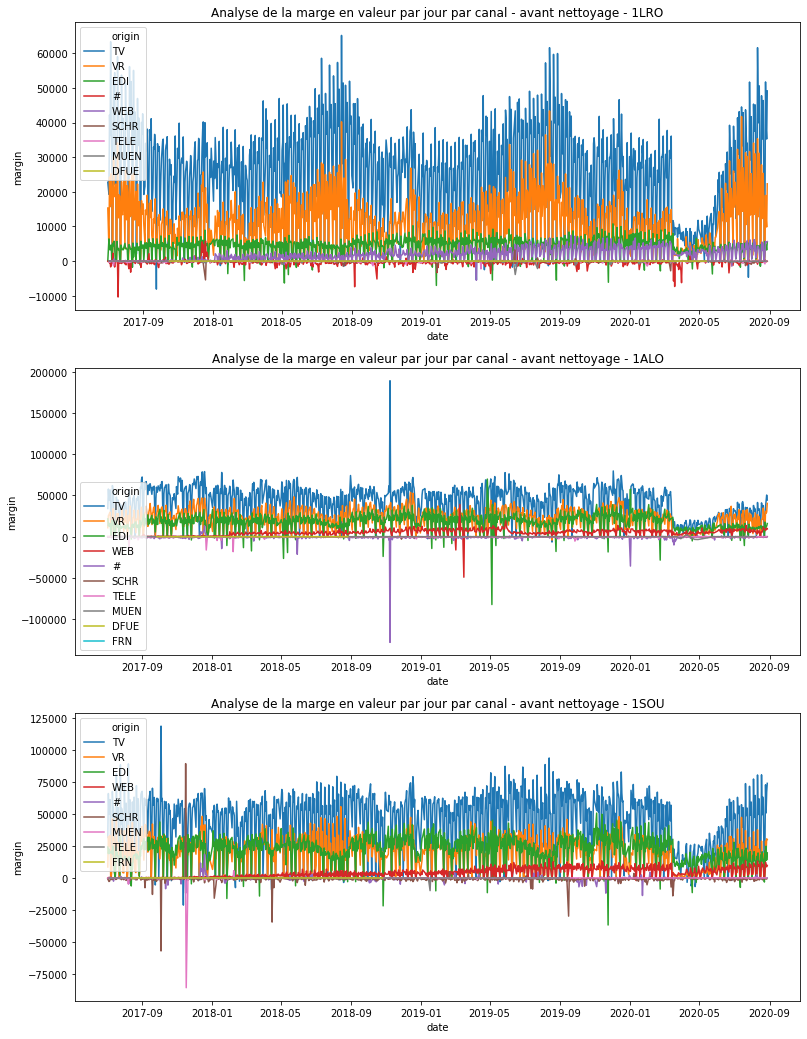

In [22]:
fig, axs = plt.subplots(figsize = (13, 18), nrows=len(data.orgacom.unique()))
orgacoms = data.orgacom.unique().tolist()
data_to_plot = [(
    data.loc[data.orgacom == orgacom]
        .groupby(['date', 'origin'])['margin']
        .sum()
        .unstack('origin')
        .rolling(1)
        .mean()
        .stack('origin')
        .rename('margin')
        .reset_index()
) for orgacom in orgacoms]

for i, data_ in enumerate(data_to_plot):
    sns.lineplot(data=data_, x='date', y='margin', hue='origin', ax=axs[i])
    axs[i].set_title(f'Analyse de la marge en valeur par jour par canal - avant nettoyage - {orgacoms[i]}')


# fig, ax = plt.subplots(figsize=(15, 12))
# data_to_plot = (
# data.loc[data.orgacom == '1ALO']
#     .groupby(['date', 'origin'])['margin']
#     .sum()
#     .unstack('origin')
#     .rolling(1)
#     .mean()
#     .stack('origin')
#     .rename('margin')
#     .reset_index()
# )
# sns.lineplot(data=data_to_plot, x='date', y='margin', hue='origin', ax=ax)
# ax.set_title('Analyse de la marge en valeur par jour par canal - avant nettoyage')
# ax.set_xticklabels([])

On voit 3 gros pics négatifs qui sont des corrections d'erreur sur les prix, mais pas affectés au canal correspondant.

### Calcul d'une table des avoirs, aggrégée

In [23]:
mask_ZC = data.doctype.isin(['ZC10'])
mask_ZA = data.doctype.isin(['ZA01', 'ZA02'])
myfields = ['orgacom',
            'doctype',
            'date',
            'origin',
            'material',
            'client',
            'brutrevenue',
            'weight',
            'PMVK',
            'marginperkg',
            'margin',
            'purchcost',
            'purchcostperkg']

In [24]:
grouper_fields = ['orgacom', 'date', 'client', 'material']
raw_avoirs = data.loc[mask_ZA, grouper_fields + ['margin', 'brutrevenue', 'weight']].copy()
avoirs = raw_avoirs.groupby(grouper_fields, observed=True).sum()
avoirs

margin  brutrevenue  weight
orgacom date       client     material                                       
1SOU    2017-07-03 0000069379 000000000000137154    2.39       -27.24  -5.000
                   0000070453 000000000000026211   -1.16        -6.74  -7.500
                   0000137251 000000000000097256  -28.66      -112.22 -15.330
                   0000137369 000000000000095083   -0.20       -14.04  -2.025
                   0000137989 000000000000095042   -0.32       -27.26  -1.152
...                                                  ...          ...     ...
1LRO    2020-08-27 0000229435 000000000000194409    0.01         0.00   0.000
                   0000230601 000000000000191742  -21.80       -34.07  -6.000
                   0000266001 000000000000012986    0.01         0.00   0.000
                              000000000000038670    0.02         0.00   0.000
                   0003002530 000000000000007321  -14.02       -32.79  -5.000

[90149 rows x 3 columns]

On identifie ensuite les lignes de commandes qui ne sont pas dupliquées dans le dataset initial.

In [25]:
mask_dup_ZC = data.loc[mask_ZC].duplicated(grouper_fields, keep=False).rename('_duplicated')
print(f'Number of duplicated lines in orders: {sum(mask_dup_ZC)}')
mask_dup_ZC = mask_dup_ZC.reindex(data.index, fill_value=False)
data = (data.merge(mask_dup_ZC, how='left', left_index=True, right_index=True))

Number of duplicated lines in orders: 545698


On calcule les indicateurs à remplacer : 
  - correspondent à des commandes, dont les lignes ne sont pas dupliquées
  - ne font pas passer les poids ou les CA bruts négatifs

In [26]:
indicators = ['margin', 'weight', 'brutrevenue']
to_update = (
data.loc[~data._duplicated & mask_ZC, grouper_fields + indicators]
    .merge(avoirs, left_on=grouper_fields, right_index=True, validate='1:1')
)
for indicator in indicators:
    to_update[indicator] = to_update[indicator + '_x'] + to_update[indicator + '_y']
to_update = to_update.loc[(to_update.weight >= 0) & (to_update.brutrevenue >= 0)]
to_update.sample(5)

,orgacom,date,client,material,margin_x,weight_x,brutrevenue_x,margin_y,brutrevenue_y,weight_y,margin,weight,brutrevenue
22370267,1LRO,2019-08-07,0000222796,000000000000014029,26.00,80.0,85.60,-3.25,-10.70,-10.0,22.75,70.0,74.9
21179739,1SOU,2019-06-17,0000222429,000000000000038713,4.84,18.0,93.22,-4.84,-93.22,-18.0,0.00,0.0,0.0
22334186,1LRO,2019-08-01,0000198131,000000000000058208,13.59,5.0,31.92,-13.59,-31.92,-5.0,0.00,0.0,0.0
862988,1ALO,2017-08-01,0000160823,000000000000030418,6.33,6.0,12.82,-6.33,-12.82,-6.0,0.00,0.0,0.0
30021455,1LRO,2020-06-14,0000138585,000000000000082853,0.07,0.0,0.00,-0.03,0.00,0.0,0.04,0.0,0.0


On contrôle que les quelques grosses lignes en erreur sont bien corrigées.

In [27]:
to_update.sort_values('margin_x', ascending=False).head(5)

,orgacom,date,client,material,margin_x,weight_x,brutrevenue_x,margin_y,brutrevenue_y,weight_y,margin,weight,brutrevenue
14479286,1ALO,2018-11-08,0000243129,000000000000026893,127569.14,150.000,127650.00,-127522.35,-127522.35,0.000,46.79,150.00,127.65
2859632,1SOU,2017-10-04,0000100449,000000000000026230,57018.93,23652.315,220203.05,-57007.65,-220159.48,-23647.635,11.28,4.68,43.57
26794767,1ALO,2020-01-02,0000027075,000000000000191247,35083.11,10.000,39461.10,-35065.55,-39421.64,0.000,17.56,10.00,39.46
8341004,1SOU,2018-04-16,0000137838,000000000000133005,33849.74,34360.000,178603.28,-33815.89,-178424.68,-34325.640,33.85,34.36,178.60
23854187,1SOU,2019-09-16,0000158986,000000000000082856,27687.64,4.800,28560.00,-27678.76,-28534.80,0.000,8.88,4.80,25.20


In [28]:
to_update.margin_y.sum()

-444364.1

On retire les indicateurs temporaires : 

In [29]:
to_update.drop(columns=['margin_x', 'margin_y', 'weight_x', 'weight_y', 'brutrevenue_x', 'brutrevenue_y'], inplace=True)

Suppression des avoirs :

In [30]:
data = data.loc[(data.merge(to_update, how='left', on=grouper_fields, indicator=True)._merge == 'left_only')
                | ~data.doctype.isin(['ZA01', 'ZA02'])]

Mise à jour des lignes de commande : 

In [31]:
merged = data.merge(to_update, on=grouper_fields, how='left', indicator=True)
del(to_update)

In [32]:
merged_mask_ZC = merged.doctype.isin(['ZC10',])
for indicator in indicators:
    merged.loc[:, indicator + '_z'] = merged[indicator + '_x'].where(merged[indicator + '_y'].isna() | ~merged_mask_ZC,
                                                                    merged[indicator + '_y'])
    
merged['margin_z'].sum()

202191096.81000006

In [33]:
for indicator in indicators:
    merged[indicator] = merged[indicator + '_z']
    merged = merged.drop(columns=[indicator + '_x', indicator + '_y', indicator + '_z'])
merged = merged.drop(columns='_merge')
data = merged
del(merged)

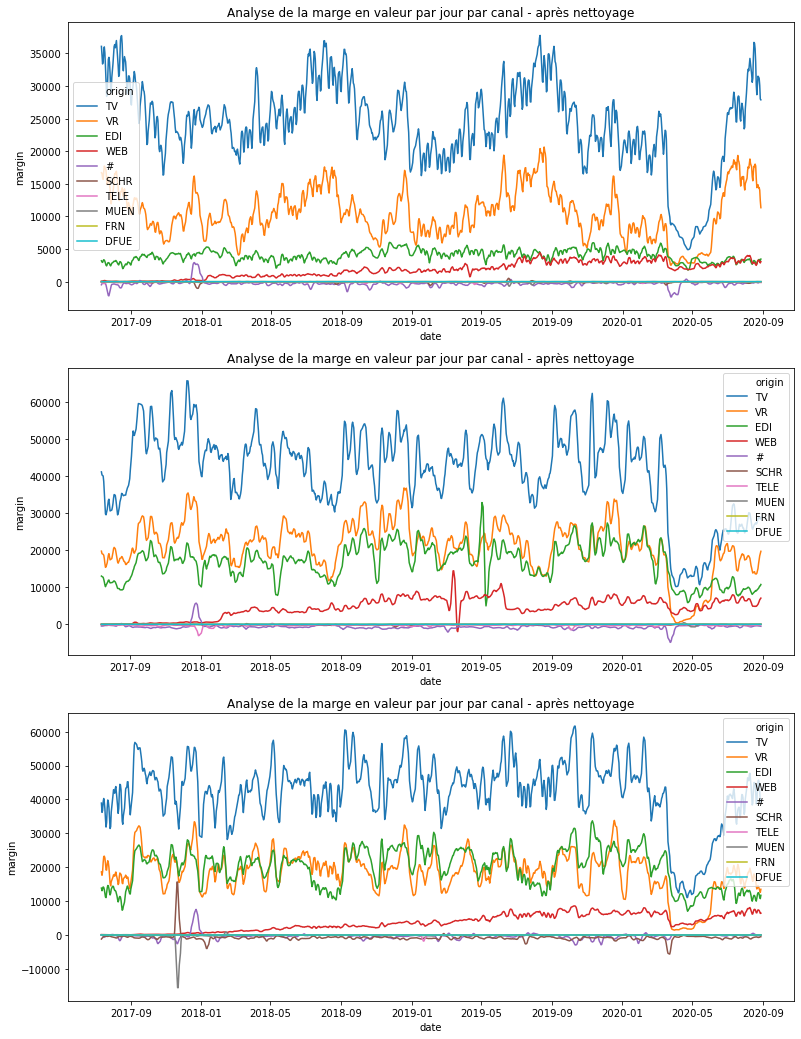

In [34]:
fig, axs = plt.subplots(figsize = (13, 18), nrows=len(data.orgacom.unique()))
data_to_plot = [(
    data.loc[data.orgacom == orgacom]
        .groupby(['date', 'origin'])['margin']
        .sum()
        .unstack('origin')
        .fillna(0.)
        .rolling(10, win_type='triang')
        .mean()
        .stack('origin')
        .rename('margin')
        .reset_index()
) for orgacom in data.orgacom.unique()]

for i, data_ in enumerate(data_to_plot):
    sns.lineplot(data=data_, x='date', y='margin', hue='origin', ax=axs[i])
    axs[i].set_title(f'Analyse de la marge en valeur par jour par canal - après nettoyage')


## Affichage des indicateurs par succursale et canal

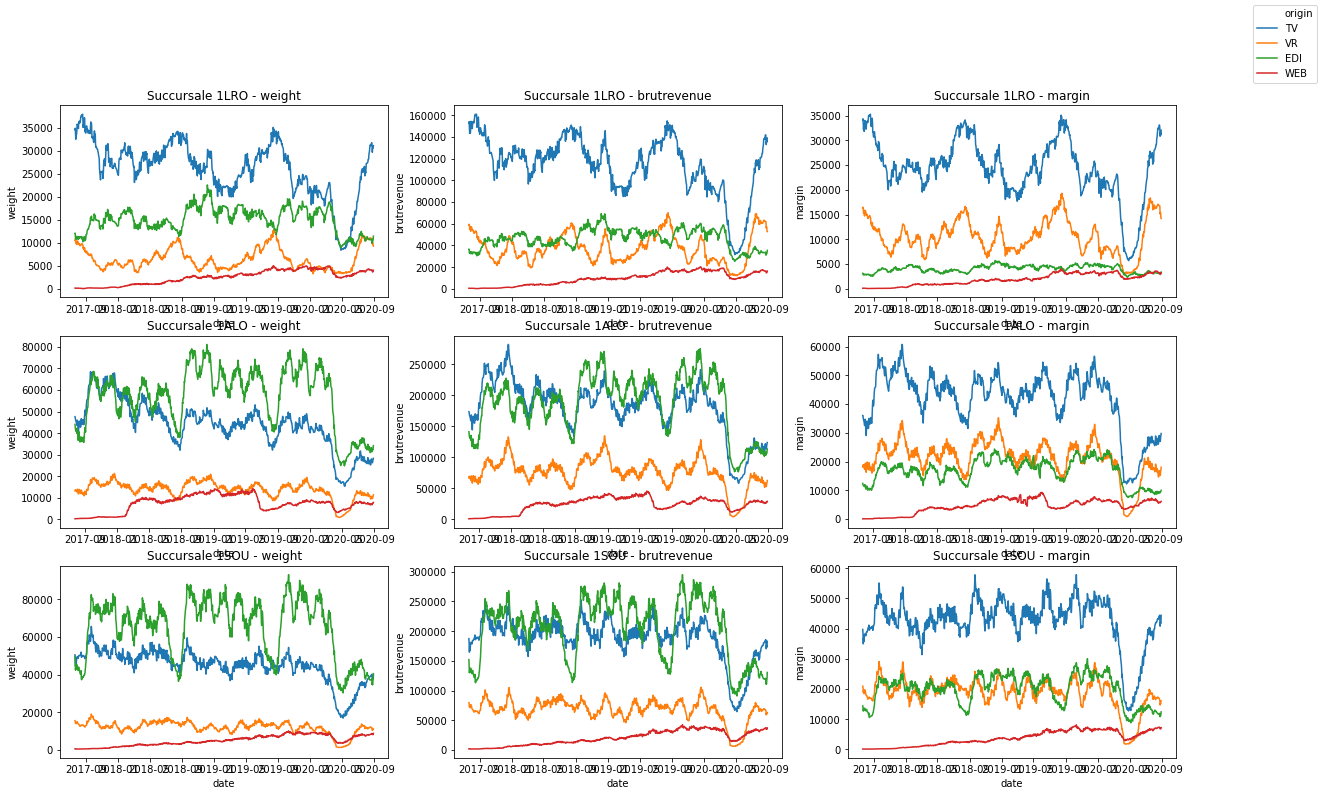

In [35]:
SV = data['orgacom'].unique()
indicators = ['weight', 'brutrevenue', 'margin']
roll_width = 20
fig, axs = plt.subplots(figsize=(20, 4 * len(SV)), nrows=len(SV), ncols=len(indicators), squeeze=False)
for i, suc in enumerate(SV):
    for j, indicator in enumerate(indicators):
        data_to_plot = (
            data.loc[(data.orgacom == suc) & data.origin.isin(['TV', 'VR', 'WEB', 'EDI'])]
                .groupby(['date', 'origin'], observed=True)[indicator]
                .sum()
                .unstack('origin')
                .fillna(0.)
                .rolling(roll_width)
                .mean()
                .stack('origin')
                .rename(indicator)
                .sort_index()
                .reset_index())
        sns.lineplot(data=data_to_plot, x='date', y=indicator, hue='origin', ax=axs[i, j])
        axs[i, j].get_legend().remove()
        axs[i, j].set_title(f'Succursale {suc} - {indicator}')
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels)


## Filtration des canaux "exotiques"

In [36]:
boxplot_args = {'showmeans': True, 
                'meanprops': {'markerfacecolor': 'black',
                              'markeredgecolor': 'black',
                              'marker': 's',
                             }
               }

In [37]:
origin2_cat = pd.CategoricalDtype(['TV', 'VR', 'EDI', 'WEB'], ordered=True)
# origins = ['TV', 'VR', 'WEB', 'EDI']
data['origin2'] = data.origin.astype(origin2_cat)

In [38]:
# fig, axs = plt.subplots(figsize=(5, 15), nrows=len(indicators), squeeze=False)
# data_to_plot = data.loc[data.origin.isin(['WEB', 'TV', 'VR', 'EDI']) &
#                         data.doctype.isin(['ZC10'])]
# for j, indicator in enumerate(indicators):
#     sns.boxplot(data=data_to_plot, y=indicator, x='orgacom', hue='origin2', ax=axs[j, 0], showfliers=False, **boxplot_args)
#     axs[j, 0].get_legend().remove()
# handles, labels = axs[0, 0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
# fig.suptitle('Analyse des postes de commandes par canal', fontsize=16, y=.925)

## Affichage des indicateurs par commande

In [39]:
aggfuncs = {
    'margin': 'sum', 
    'brutrevenue': 'sum',
    'weight': 'sum',
    'origin2': 'size',
}
orders = (
    data.loc[(data.doctype == 'ZC10') & (data.weight > 0.) & (data.brutrevenue > 0.)]
        .groupby(['orgacom', 'date', 'client', 'origin2'], observed=True)
        .agg(aggfuncs)
        .rename({'origin2': 'linecount'}, axis=1)
)
print(f'{len(orders)} records in order dataframe before canal deduplication')
orders

2342199 records in order dataframe before canal deduplication


margin  brutrevenue  weight  linecount
orgacom date       client     origin2                                        
1SOU    2017-07-03 0000065940 TV        31.16        84.01   5.501          9
                   0000065945 TV         6.02        23.69   3.734          2
                   0000065975 TV        25.15        97.40  13.718          1
                   0000065998 TV         4.12         8.56   1.000          1
                   0000066014 TV        17.89        48.30   5.000          1
...                                       ...          ...     ...        ...
1LRO    2020-08-28 0000285485 TV        10.05        30.34   4.045          1
                              VR       106.57       314.40  41.414         13
                   0000285532 VR        97.39       654.05  90.556         12
                   0003004575 VR        16.83        49.75   5.000          1
                   SL0071     TV        13.93       229.58  47.500          2

[2342199 rows x 4 columns]

### Calcul du canal majoritaire par OC, client, jour

On considère le canal de la commande comme étant le canal qui représente le plus en poids pour un jour donné.

In [40]:
major_canal = orders['weight'].unstack(fill_value=0.).idxmax(axis=1).rename('origin2')
major_canal

orgacom  date        client    
1SOU     2017-07-03  0000065940     TV
                     0000065945     TV
                     0000065975     TV
                     0000065998     TV
                     0000066014     TV
                                  ... 
1LRO     2020-08-28  0000283698    EDI
                     0000284259    EDI
                     0000285463     VR
                     0000285485     VR
                     0000285532     VR
Name: origin2, Length: 2074208, dtype: object

In [41]:
orders = orders.groupby(level=[0, 1, 2], observed=True).sum().join(major_canal)
del(major_canal)
print(f'{len(orders)} records in order dataframe after canal deduplication')
orders

2074208 records in order dataframe after canal deduplication


margin  brutrevenue  weight  linecount origin2
orgacom date       client                                                    
1SOU    2017-07-03 0000065940   31.16        84.01   5.501          9      TV
                   0000065945    6.02        23.69   3.734          2      TV
                   0000065975   25.15        97.40  13.718          1      TV
                   0000065998    4.12         8.56   1.000          1      TV
                   0000066014   17.89        48.30   5.000          1      TV
...                               ...          ...     ...        ...     ...
1LRO    2020-08-28 0000285463   98.81       393.49  64.964         15      VR
                   0000285485  116.62       344.74  45.459         14      VR
                   0000285532   97.39       654.05  90.556         12      VR
                   0003004575   16.83        49.75   5.000          1      VR
                   SL0071       13.93       229.58  47.500          2      TV

[2074208 rows x 5 columns]

On ajoute quelques données du dataset client.

In [42]:
clt_fields = ['seg1', 'seg2', 'seg3', 'seg4', 'cat', 'sscat', 'hier4']
for field in clt_fields:
    try:
        orders = orders.drop(field)
    except: 
        pass
orders = orders.merge(df_clt.loc[:, clt_fields], left_on=['orgacom', 'client'], right_index=True, validate='m:1')

In [43]:
orders['PMVK'] = orders.brutrevenue / orders.weight
orders['marginperkg'] = orders.margin / orders.weight
orders['marginpercent'] = orders.margin / orders.brutrevenue
orders['lineweight'] = orders.weight / orders.linecount
orders = orders.reset_index()

Text(0.5, 0.91, 'Analyse des commandes par canal')

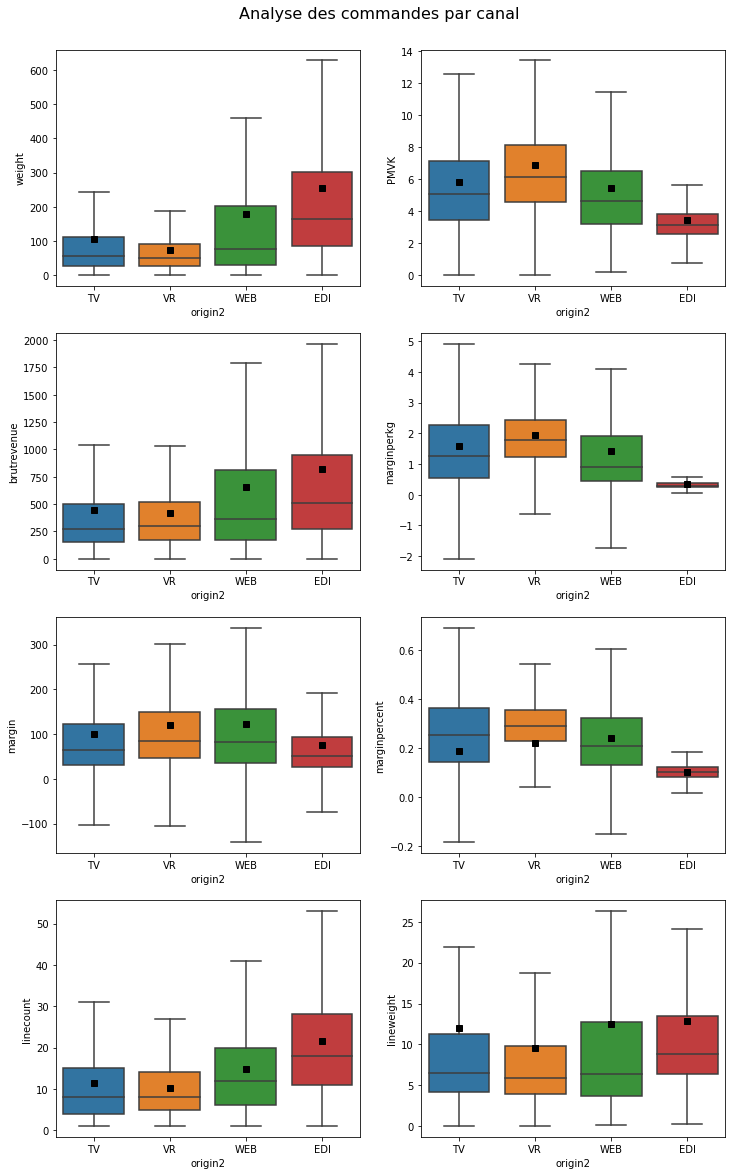

In [44]:
indicators2 = ['weight', 'brutrevenue', 'margin', 'linecount', 'PMVK', 'marginperkg', 'marginpercent', 'lineweight']
fig, axs = plt.subplots(figsize=(12, 20), nrows=len(indicators2) // 2, ncols=2, squeeze=False)
for j, indicator in enumerate(indicators2):
    x, y = j % (len(indicators2) // 2), j // (len(indicators2) // 2)
    sns.boxplot(data=orders, y=indicator, x='origin2', hue=None, ax=axs[x, y], showfliers=False, **boxplot_args)
fig.suptitle('Analyse des commandes par canal', fontsize=16, y=.91)

In [45]:
orders.groupby('origin2').margin.describe()

,count,mean,std,min,25%,50%,75%,max
origin2,,,,,,,,
EDI,526279.0,76.625026,99.484911,-5430.55,26.0800,50.22,92.37,9880.62
TV,1053378.0,100.630820,144.298068,-6435.52,31.4600,63.67,121.72,26866.17
VR,412475.0,120.328828,129.804025,-2102.62,46.7800,83.66,148.80,7727.90
WEB,82072.0,123.086542,145.378463,-378.54,36.2775,81.58,157.01,6681.78


In [46]:
orders.groupby(['origin2']).mean().loc[:, indicators2].style.format(formats)

,weight,brutrevenue,margin,linecount,PMVK,marginperkg,marginpercent,lineweight
origin2,,,,,,,,
EDI,253.84 kg,817.78 €,76.63 €,21.59,3.42 €/kg,0.34 €/kg,10.24%,12.88 kg
TV,106.04 kg,445.45 €,100.63 €,11.44,5.83 €/kg,1.58 €/kg,18.91%,11.95 kg
VR,74.86 kg,419.89 €,120.33 €,10.19,6.89 €/kg,1.96 €/kg,22.00%,9.60 kg
WEB,179.24 kg,657.36 €,123.09 €,14.90,5.46 €/kg,1.44 €/kg,23.82%,12.54 kg


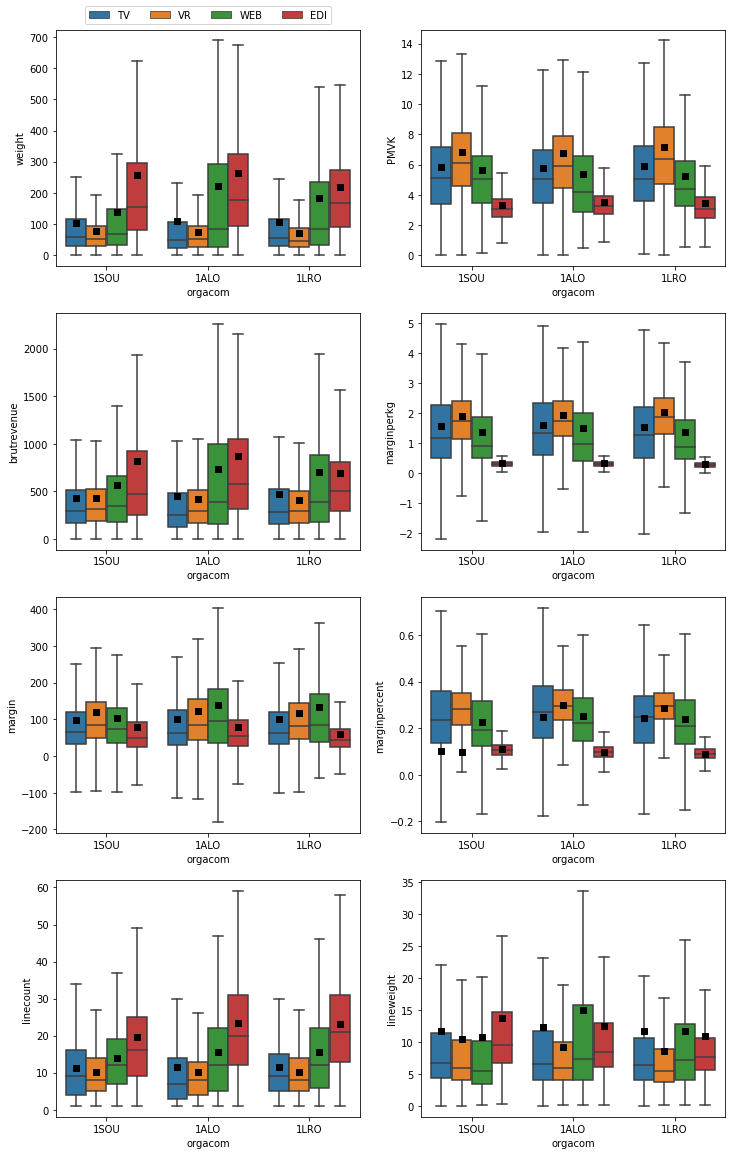

In [47]:
fig, axs = plt.subplots(figsize=(12, 20), nrows=len(indicators2) // 2, ncols=2, squeeze=False)
for j, indicator in enumerate(indicators2):
    x, y = j % (len(indicators2) // 2), j // (len(indicators2) // 2)
    sns.boxplot(data=orders, y=indicator, x='orgacom', hue='origin2', ax=axs[x, y], showfliers=False, **boxplot_args)
    axs[x, y].get_legend().remove()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )

In [48]:
orders.groupby(['orgacom', 'origin2']).mean().loc[:, indicators2].style.format(formats)

In [49]:
vr_1SOU = orders.loc[(orders.orgacom == '1SOU') & (orders.origin2 == 'VR')]
print(f'{vr_1SOU.loc[(vr_1SOU.marginpercent == vr_1SOU.marginpercent.min())].marginpercent.iloc[0]:.2%}')
vr_1SOU.loc[(vr_1SOU.marginpercent == vr_1SOU.marginpercent.min()), :]

-210400.00%


,orgacom,date,client,margin,brutrevenue,weight,linecount,origin2,seg1,seg2,seg3,seg4,cat,sscat,hier4,PMVK,marginperkg,marginpercent,lineweight
3768,1SOU,2019-12-10,0000066228,-42.08,0.02,2.0,1,VR,Z3,Z4,ZI,ZB,ZM,Z16,10838,0.01,-21.04,-2104.0,2.0


In [50]:
data.loc[(data.orgacom == '1SOU') &
         (data.client == '0000140169') &
         (data.date == '2019-04-02') &
         (data.origin == 'VR')]

,order_num,orgacom,month,week,date,pricetype,client,doctype,origin,salesgroup,...,marginperkg,purchcost,purchcostperkg,PMVK,marginpercent,_duplicated,margin,weight,brutrevenue,origin2
18688639,1304465,1SOU,201904,201914,2019-04-02,ZTG,0000140169,ZC10,VR,791,...,-8.56,21.42,8.568,0.004,-2141.0,False,-21.41,2.5,0.01,VR


In [51]:
dicted_clt_fields = {key: 'object' for key in clt_fields}

[Text(0, 0, 'ZI - Restau Coll. Autogérée'),
 Text(1, 0, 'ZL - Restau Com. Structurée'),
 Text(2, 0, 'ZK - Restau Com. Indépendante'),
 Text(3, 0, 'ZJ - Restau Coll. Concédée')]

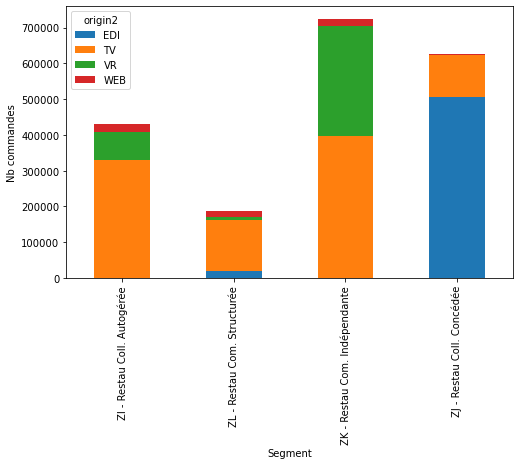

In [52]:
mask_filter = (orders.seg1.isin(['Z3']) & (orders.hier4 != '198863'))

fig, ax = plt.subplots(figsize=(8, 5))
(
orders.loc[mask_filter]
      .pivot_table(index='seg3',
                   columns='origin2',
                   aggfunc='size',
                   observed=True)
      .plot(kind='bar', stacked=True, ax=ax)
)
ax.set_ylabel('Nb commandes')
ax.set_xlabel('Segment')
ax.set_xticklabels(['ZI - Restau Coll. Autogérée',
                    'ZL - Restau Com. Structurée',
                    'ZK - Restau Com. Indépendante', 
                    'ZJ - Restau Coll. Concédée'])
    

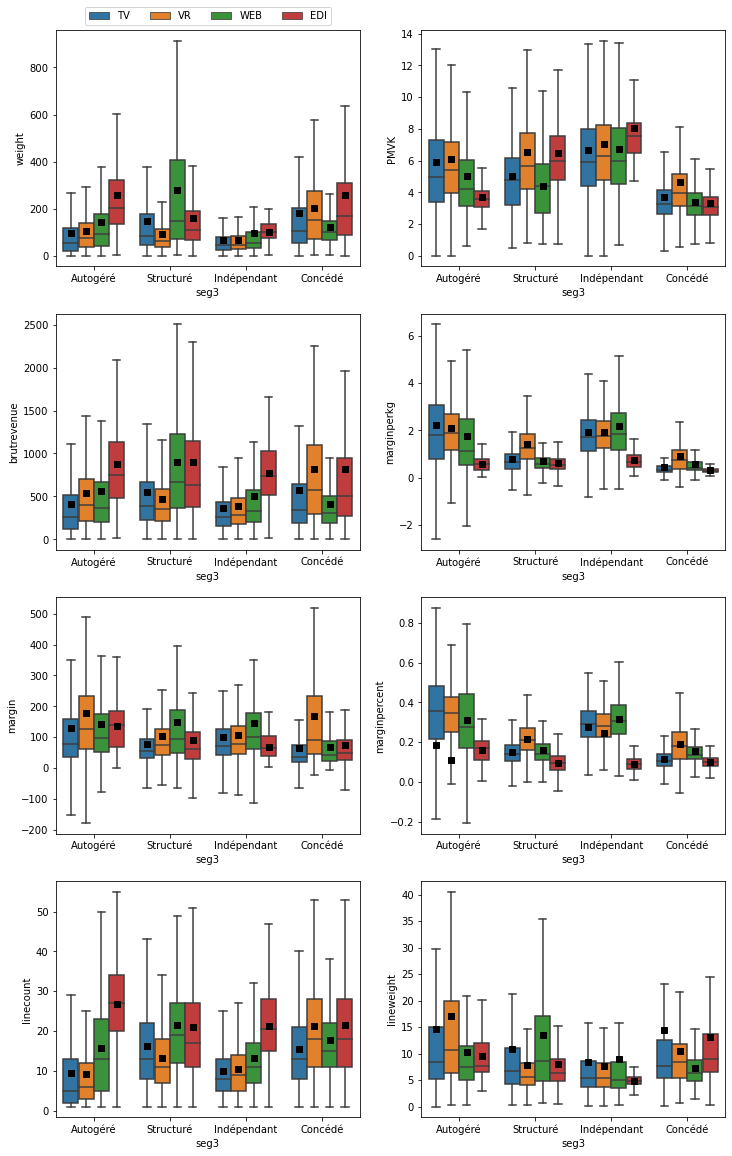

In [53]:
fig, axs = plt.subplots(figsize=(12, 20), nrows=len(indicators2) // 2, ncols=2, squeeze=False)
for j, indicator in enumerate(indicators2):
    x, y = j % (len(indicators2) // 2), j // (len(indicators2) // 2)
    sns.boxplot(data=orders.astype(dicted_clt_fields).loc[mask_filter],
                y=indicator,
                x='seg3',
                hue='origin2',
                ax=axs[x, y],
                showfliers=False, 
                **boxplot_args,
               )
    axs[x, y].get_legend().remove()
    texts = [lib_seg.loc[(3, text.get_text())].iloc[0] for text in axs[x, y].get_xticklabels()]
    axs[x, y].set_xticklabels(texts)
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )

In [54]:
(
orders.loc[orders.seg1.isin(['Z3']), indicators2 + ['orgacom', 'seg3']]
      .groupby(['orgacom', 'seg3'], observed=True)
      .mean()
      .style.format(formats)
)

## Impact du Web sur les indicateurs, à la maille du client

On calcule le zscore sur les indicateurs suivis, **à la maille du client DO**.

In [55]:
for indicator in indicators2:
    grouped = orders.groupby(['orgacom', 'client'], observed=True)
    orders[indicator + '_clt_mean'] = grouped[indicator].transform('mean')
    orders[indicator + '_clt_std'] = grouped[indicator].transform('std')
    orders[indicator + '_clt_zscore'] = ((orders[indicator] - orders[indicator + '_clt_mean']) /
                                         orders[indicator + '_clt_std']).replace([np.inf, -np.inf], np.nan).fillna(0.)
    del(orders[indicator + '_clt_mean'])
    del(orders[indicator + '_clt_std'])
    print(f'{indicator} done!')
print('ALL DONE!')

weight done!
brutrevenue done!
margin done!
linecount done!
PMVK done!
marginperkg done!
marginpercent done!
lineweight done!
ALL DONE!


In [56]:
orders.describe().style.format('{:.5f}')

,margin,brutrevenue,weight,linecount,PMVK,marginperkg,marginpercent,lineweight,weight_clt_zscore,brutrevenue_clt_zscore,margin_clt_zscore,linecount_clt_zscore,PMVK_clt_zscore,marginperkg_clt_zscore,marginpercent_clt_zscore,lineweight_clt_zscore
count,2074204.00000,2074204.00000,2074204.00000,2074204.00000,2074204.00000,2074204.00000,2074204.00000,2074204.00000,2074204.00000,2074204.00000,2074204.00000,2074204.00000,2074204.00000,2074204.00000,2074204.00000,2074204.00000
mean,99.34559,543.22269,140.23609,13.90242,5.41766,1.33661,0.17517,11.74024,0.00000,-0.00000,0.00000,0.00000,-0.00000,-0.00000,0.00000,0.00000
std,132.34068,874.01110,251.89970,17.70310,3.77039,1.97494,8.50864,27.66331,0.99396,0.99397,0.99398,0.99333,0.99397,0.99398,0.99398,0.99396
min,-6435.52000,0.01000,0.01000,1.00000,0.00400,-58.00667,-2106.00000,0.01000,-7.80330,-5.95982,-18.44072,-8.00962,-8.15881,-20.55222,-20.83743,-6.35392
25%,32.33000,174.98000,33.04100,5.00000,3.11144,0.33622,0.10941,4.54000,-0.68757,-0.67508,-0.66493,-0.68053,-0.57862,-0.54882,-0.58698,-0.59452
50%,63.96000,328.90500,71.48800,10.00000,4.50638,0.93057,0.20235,7.08667,-0.12470,-0.15552,-0.15872,-0.08062,-0.15807,-0.14274,-0.02123,-0.15814
75%,121.07000,619.97000,156.27500,18.00000,6.65602,1.99152,0.32275,11.72734,0.57336,0.53068,0.50354,0.60518,0.38832,0.37632,0.55784,0.41147
max,26866.17000,83247.52000,14277.92000,1053.00000,488.83333,1703.66650,166.17210,4800.00000,16.37792,15.86674,21.12977,13.35556,20.38970,20.77288,23.55050,20.94002


Pour un client donné, cela ne change pas le rapport entre les divers indicateurs :

0000238202 - CASINO CLIN MUT PESSAC


<AxesSubplot:xlabel='date'>

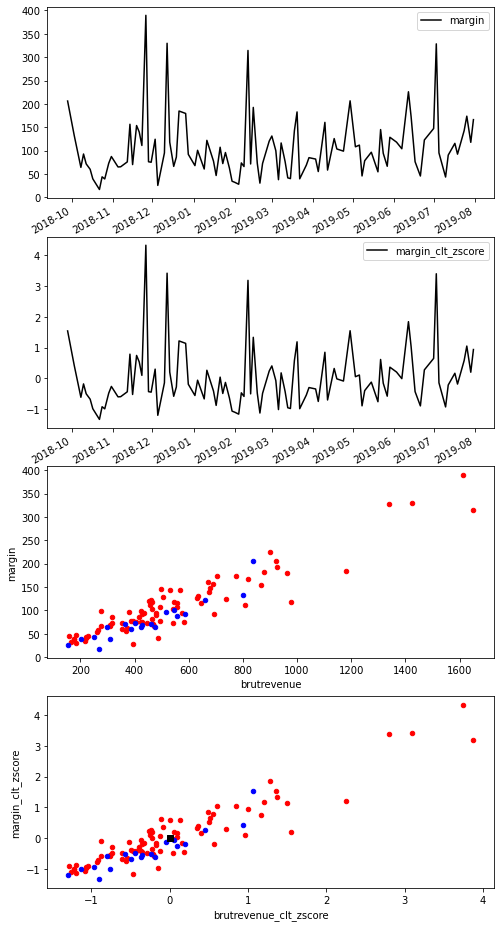

In [57]:
sample = orders.loc[orders.origin2 == 'WEB'].sample(1).iloc[0]
oc, client = sample.orgacom, sample.client
name = df_clt.loc[(oc, client), 'nom']
print(f'{client} - {name}')
fig, axs = plt.subplots(figsize=(8, 18), nrows=4)
mask_clt = (orders.client == client)
mask_web = mask_clt & (orders.origin2 == 'WEB')
mask_other = mask_clt & (orders.origin2 != 'WEB')
orders.loc[mask_web].plot(kind='scatter', y='margin', x='brutrevenue', color='red', ax=axs[2])
orders.loc[mask_other].plot(kind='scatter', y='margin', x='brutrevenue', color='blue', ax=axs[2])
orders.loc[mask_web].plot(kind='scatter', y='margin_clt_zscore', x='brutrevenue_clt_zscore', color='red', ax=axs[3])
orders.loc[mask_other].plot(kind='scatter', y='margin_clt_zscore', x='brutrevenue_clt_zscore', color='blue', ax=axs[3])
axs[3].scatter(x=[0], y=[0], marker='s', color='black')
orders.loc[mask_clt].plot(kind='line', y='margin', x='date', color='black', ax=axs[0])
orders.loc[mask_clt].plot(kind='line', y='margin_clt_zscore', x='date', color='black', ax=axs[1])

### Un exemple issu d'O'Tacos

0000215862 - O TACOS NANCY


<AxesSubplot:xlabel='date'>

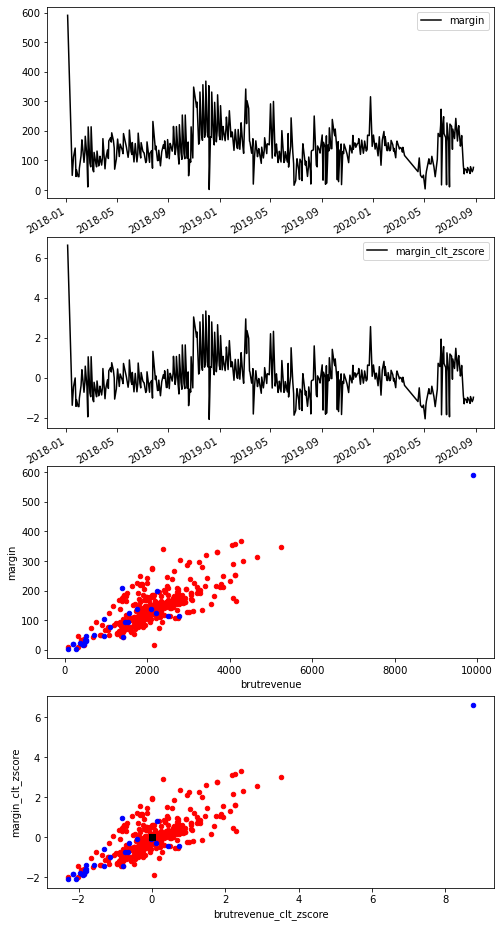

In [58]:
sample = orders.loc[(orders.origin2 == 'WEB') & (orders.hier4 == '198863')].sample(1).iloc[0]
oc, client = sample.orgacom, sample.client
name = df_clt.loc[(oc, client), 'nom']
print(f'{client} - {name}')
fig, axs = plt.subplots(figsize=(8, 18), nrows=4)
mask_clt = (orders.client == client)
mask_web = mask_clt & (orders.origin2 == 'WEB')
mask_other = mask_clt & (orders.origin2 != 'WEB')
orders.loc[mask_web].plot(kind='scatter', y='margin', x='brutrevenue', color='red', ax=axs[2])
orders.loc[mask_other].plot(kind='scatter', y='margin', x='brutrevenue', color='blue', ax=axs[2])
orders.loc[mask_web].plot(kind='scatter', y='margin_clt_zscore', x='brutrevenue_clt_zscore', color='red', ax=axs[3])
orders.loc[mask_other].plot(kind='scatter', y='margin_clt_zscore', x='brutrevenue_clt_zscore', color='blue', ax=axs[3])
axs[3].scatter(x=[0], y=[0], marker='s', color='black')
orders.loc[mask_clt].plot(kind='line', y='margin', x='date', color='black', ax=axs[0])
orders.loc[mask_clt].plot(kind='line', y='margin_clt_zscore', x='date', color='black', ax=axs[1])

Par contre, cela change les indicateurs si 

<AxesSubplot:xlabel='brutrevenue_clt_zscore', ylabel='margin_clt_zscore'>

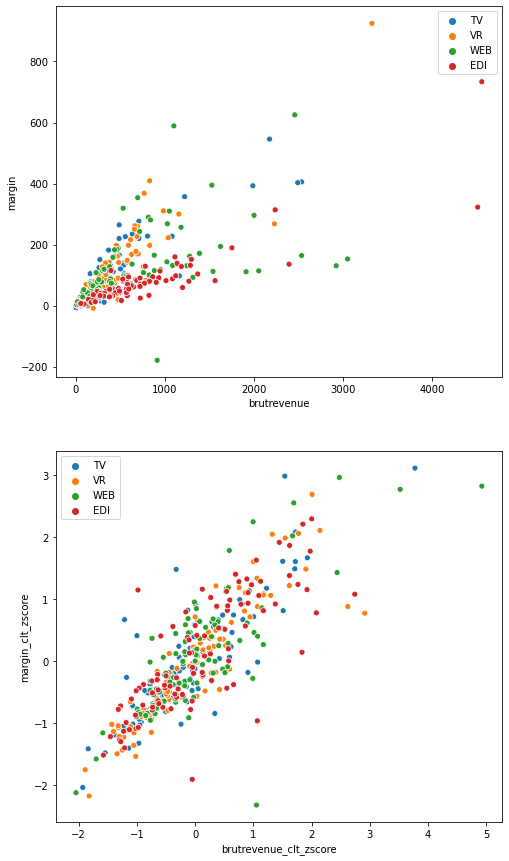

In [59]:
df_sample = pd.concat([orders.loc[orders.origin2 == origin].sample(100) for origin in orders.origin2.unique()], axis=0)

fig, axs = plt.subplots(nrows=2, figsize=(8, 15))
sns.scatterplot(data=df_sample, x='brutrevenue', y='margin', hue=df_sample.origin2.tolist(), ax=axs[0])
sns.scatterplot(data=df_sample, x='brutrevenue_clt_zscore', y='margin_clt_zscore', hue=df_sample.origin2.tolist(), ax=axs[1])

Text(0.5, 0.91, 'Analyse des commandes par canal')

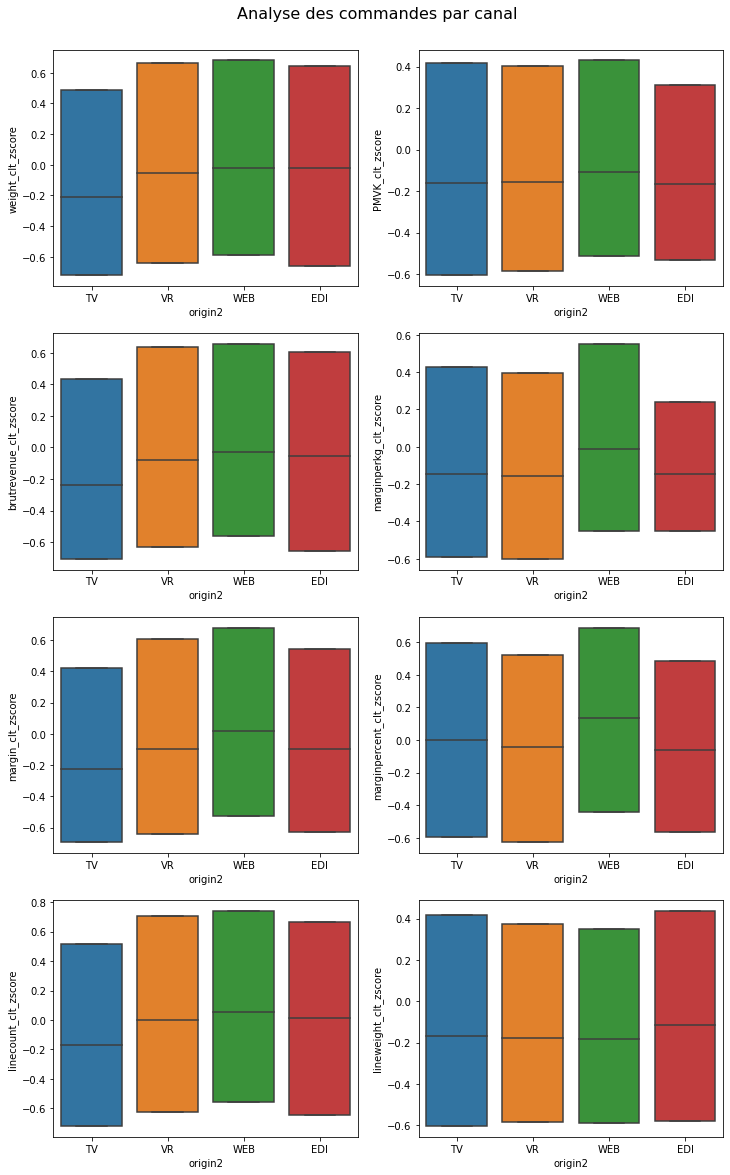

In [60]:
fig, axs = plt.subplots(figsize=(12, 20), nrows=len(indicators2) // 2, ncols=2, squeeze=False)
for j, indicator in enumerate(indicators2):
    x, y = j % (len(indicators2) // 2), j // (len(indicators2) // 2)
    sns.boxplot(data=orders, y=indicator + '_clt_zscore', x='origin2', hue=None, ax=axs[x, y], showfliers=False, whis=0.)
fig.suptitle('Analyse des commandes par canal', fontsize=16, y=.91)

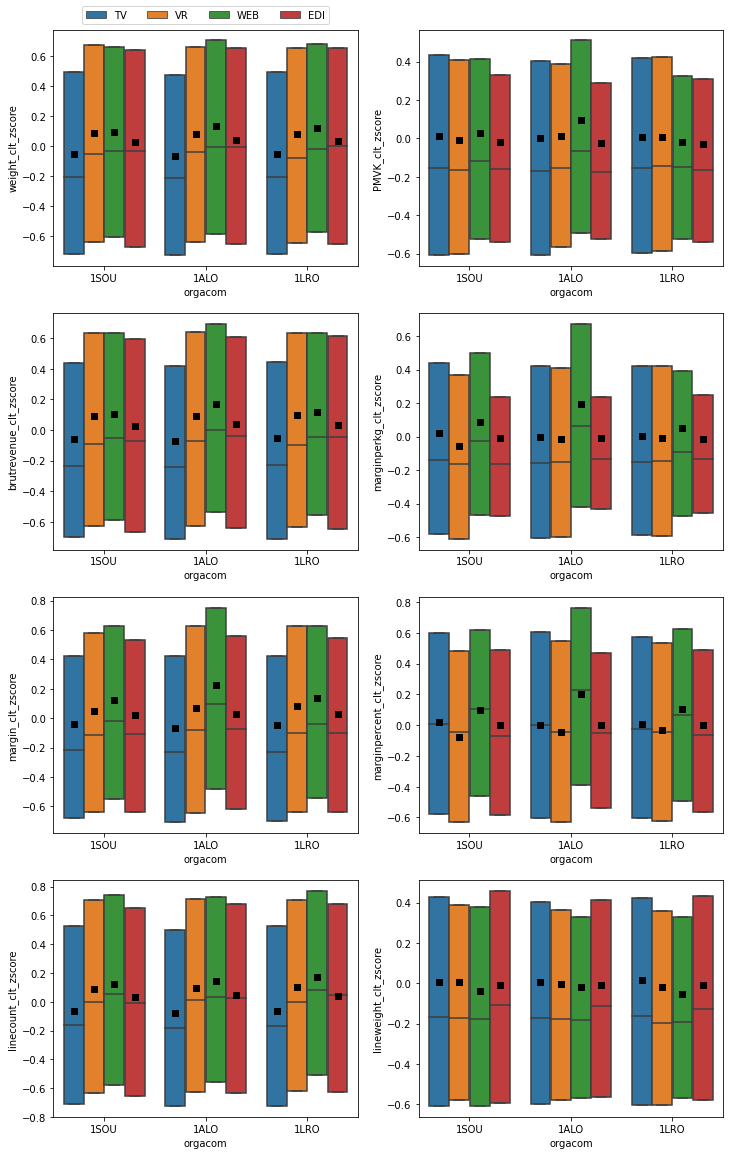

In [61]:
fig, axs = plt.subplots(figsize=(12, 20), nrows=len(indicators2) // 2, ncols=2, squeeze=False)
for j, indicator in enumerate(indicators2):
    x, y = j % (len(indicators2) // 2), j // (len(indicators2) // 2)
    sns.boxplot(data=orders,
                y=indicator + '_clt_zscore',
                x='orgacom',
                hue='origin2',
                ax=axs[x, y],
                showfliers=False,
                whis=0.,
                **boxplot_args,
               )
    axs[x, y].get_legend().remove()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )

Text(0.5, 1.025, 'Analyse vs. moyenne des commandes par canal et segment de restauration')

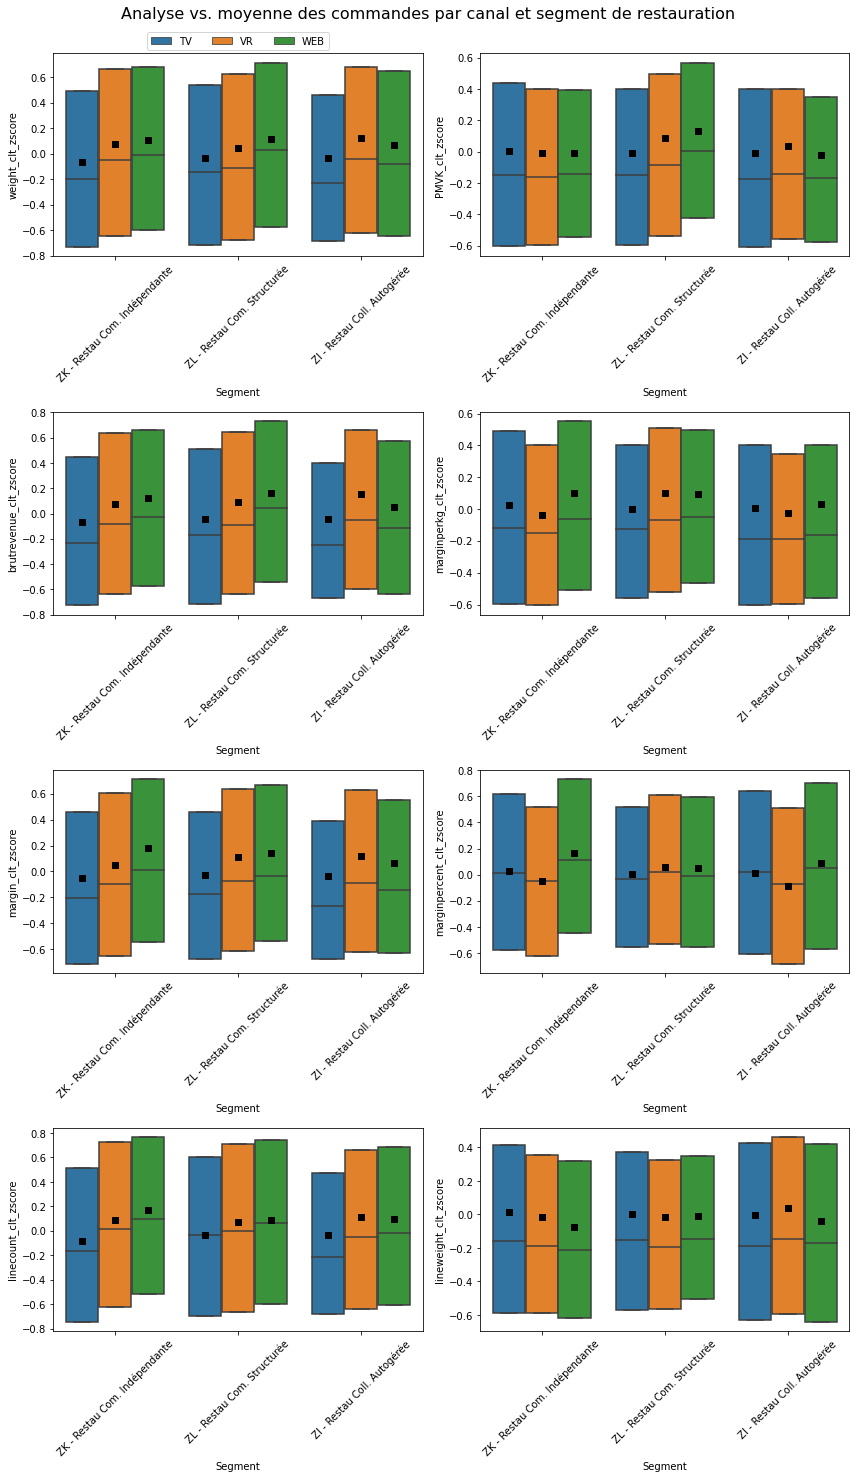

In [62]:
fig, axs = plt.subplots(figsize=(12, 20), nrows=len(indicators2) // 2, ncols=2, squeeze=False)
for j, indicator in enumerate(indicators2):
    x, y = j % (len(indicators2) // 2), j // (len(indicators2) // 2)
    sns.boxplot(data=orders.loc[mask_filter & #.astype(dicted_clt_fields)
                                ~orders.seg3.isin(['ZJ']) &
                                ~orders.origin2.isin(['EDI'])],
                y=indicator + '_clt_zscore',
                x='seg3',
                order=['ZK', 'ZL', 'ZI'],
                hue='origin2',
                hue_order=['TV', 'VR', 'WEB'],
                ax=axs[x, y],
                showfliers=False,
                whis=0.,
                **boxplot_args,
               )
    axs[x, y].get_legend().remove()
    axs[x, y].set_xlabel('Segment')
    axs[x, y].set_xticklabels([
                               'ZK - Restau Com. Indépendante', 
                               'ZL - Restau Com. Structurée',
                               'ZI - Restau Coll. Autogérée',                               
#                                'ZJ - Restau Coll. Concédée',
                              ])
    axs[x, y].xaxis.set_tick_params(rotation=45.)
fig.tight_layout()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
fig.suptitle('Analyse vs. moyenne des commandes par canal et segment de restauration', fontsize=16, y=1.025)

## Première modélisation : bascule à la première commande Web

Dans un premier temps, on va considérer que la bascule se fait à la première commande Web. Les hypothèses sont : 
- le statut est initialement le canal de la première commande
- ensuite, il est 'WEB' à partir de la première commande web

On commence par calculer le statut initial de chaque client

In [63]:
first_order = (
orders.groupby(['orgacom', 'client'], observed=True)['date']
      .min()
      .reset_index()
)

On initialise la table des mises à jour de statuts :

In [64]:
status_updates = (
    orders[['orgacom',
            'client',
            'date',
            'origin2']].merge(first_order,
                              on=['orgacom', 'client', 'date'],
                              how='inner',
                              validate='1:1')
                       .rename({'origin2': 'new_stat'}, axis=1)
                       .set_index(['orgacom', 'client', 'date'])
)

On complète en ajoutant la première commande WEB (si elle n'est pas également la première commande).

In [65]:
status_updates2 = (
orders.loc[orders.origin2 == 'WEB']
      .groupby(['client', 'orgacom'], observed=True)['date']
      .min()
      .reset_index()
      .set_index(['orgacom', 'client', 'date'])
)
status_updates2['new_stat'] = 'WEB'
status_updates = (status_updates.append(status_updates2.loc[~status_updates2.index.isin(status_updates.index)])
                                .sort_values(['orgacom', 'client', 'date'])
                 )
status_updates = status_updates.sort_index()
del(status_updates2)
if len(status_updates.loc[status_updates.index.duplicated(keep=False)]) > 0.:
    raise RuntimeError('Something went wrong in computing statuses!')

In [66]:
status_updates

new_stat
orgacom client     date               
1SOU    0000010078 2017-07-17       TV
                   2017-11-06      WEB
        0000019613 2017-07-04       TV
        0000043428 2017-07-04       TV
        0000043827 2019-07-12       VR
...                                ...
1LRO    SL0028     2017-11-16       TV
        SL003F     2019-07-02       TV
        SL0071     2017-07-05       TV
        SL0073     2020-01-22       TV
        SL009G     2017-10-12       TV

[27687 rows x 1 columns]

Ajout de 2 lignes de test dans la table des mises à jour de statut.

In [67]:
# status_updates.loc[('1LRO', '0000096476', pd.to_datetime('2018-01-01'))] = 'TEST1'
# status_updates.loc[('1LRO', '0000096476', pd.to_datetime('2019-04-27'))] = 'TEST2'
# status_updates.loc[idx[:, '0000096476', :]]

In [68]:
statuses = (
    status_updates.reindex(status_updates.index.union(orders.set_index(['orgacom', 'client', 'date']).index))
                  .sort_index()
                  .fillna(method='ffill')
                  .rename({'new_stat': 'clt_stat'}, axis=1)
)
orders2 = (
orders.set_index(['orgacom', 'client', 'date'])
      .merge(statuses, left_index=True, right_index=True, how='left', indicator=True, validate='1:1')
)
if len(orders2.loc[orders2._merge != 'both']) > 0: 
    raise RuntimeError('Something went wrong during statuses computation')
if len(orders2) != len(orders):
    raise RuntimeError('Something went wrong during statuses computation')
orders = orders2
del(statuses)
del(orders['_merge'])

In [69]:
orders

margin  brutrevenue   weight  linecount  \
orgacom client     date                                                  
1SOU    0000065940 2017-07-03   31.16        84.01    5.501          9   
                   2017-08-28   44.36       105.93    8.048         10   
                   2017-09-08   17.60        40.35    3.000          2   
                   2017-09-15  100.12       236.77   20.312          3   
                   2017-09-25   96.04       253.99   40.338          5   
...                               ...          ...      ...        ...   
1LRO    0000282900 2020-08-27   84.70      1732.19  477.098         24   
        0000284259 2020-08-28   17.60       134.92   53.300          8   
        0000285463 2020-08-28   98.81       393.49   64.964         15   
        0000285485 2020-08-28  116.62       344.74   45.459         14   
        0000285532 2020-08-28   97.39       654.05   90.556         12   

                              origin2 seg1 seg2 seg3 seg4 cat  ... lineweight  \
orgacom client     date                                        ...              
1SOU    0000065940 2017-07-03      TV   Z3   Z4   ZI   ZB  ZL  ...   0.611222   
                   2017-08-28      TV   Z3   Z4   ZI   ZB  ZL  ...   0.804800   
                   2017-09-08      TV   Z3   Z4   ZI   ZB  ZL  ...   1.500000   
                   2017-09-15      TV   Z3   Z4   ZI   ZB  ZL  ...   6.770667   
                   2017-09-25      TV   Z3   Z4   ZI   ZB  ZL  ...   8.067600   
...                               ...  ...  ...  ...  ...  ..  ...        ...   
1LRO    0000282900 2020-08-27      TV   Z3   Z4   ZI   ZD  ZL  ...  19.879083   
        0000284259 2020-08-28     EDI   Z3   Z4   ZJ   ZF  ZO  ...   6.662500   
        0000285463 2020-08-28      VR   Z3   Z5   ZK   ZG  ZU  ...   4.330933   
        0000285485 2020-08-28      VR   Z3   Z5   ZK   ZG  ZS  ...   3.247071   
        0000285532 2020-08-28      VR   Z3   Z5   ZK   ZG  ZS  ...   7.546333   

                              weight_clt_zscore  brutrevenue_clt_zscore  \
orgacom client     date                                                   
1SOU    0000065940 2017-07-03         -0.530799               -0.420589   
                   2017-08-28         -0.480297               -0.376466   
                   2017-09-08         -0.580390               -0.508474   
                   2017-09-15         -0.237125               -0.113095   
                   2017-09-25          0.159954               -0.078432   
...                                         ...                     ...   
1LRO    0000282900 2020-08-27          0.000000                0.000000   
        0000284259 2020-08-28          0.000000                0.000000   
        0000285463 2020-08-28          0.000000                0.000000   
        0000285485 2020-08-28          0.000000                0.000000   
        0000285532 2020-08-28          0.000000                0.000000   

                               margin_clt_zscore  linecount_clt_zscore  \
orgacom client     date                                                  
1SOU    0000065940 2017-07-03          -0.515855              2.795673   
                   2017-08-28          -0.423595              3.252761   
                   2017-09-08          -0.610631             -0.403938   
                   2017-09-15          -0.033868              0.053150   
                   2017-09-25          -0.062385              0.967324   
...                                          ...                   ...   
1LRO    0000282900 2020-08-27           0.000000              0.000000   
        0000284259 2020-08-28           0.000000              0.000000   
        0000285463 2020-08-28           0.000000              0.000000   
        0000285485 2020-08-28           0.000000              0.000000   
        0000285532 2020-08-28           0.000000              0.000000   

                               PMVK_clt_zscore  marginperkg_clt_zscore  \
o

In [97]:
sample_clt = '0000096476'
to_plot = orders.loc[idx['1LRO', sample_clt, :]].copy()
to_plot['color'] = to_plot['origin2'].map(colors)
colors = {'TV': 'blue', 'VR': 'orange', 'WEB': 'green'}
to_plot

margin  brutrevenue  weight  linecount origin2  \
orgacom client     date                                                         
1LRO    0000096476 2017-07-06    3.97         8.24   1.303          1      TV   
                   2017-07-11   27.48        64.95   6.837          1      TV   
                   2017-07-13   18.10        31.14  10.000          1      TV   
                   2017-07-20   54.09       127.83   9.936          1      TV   
                   2017-07-25   61.84       112.14  20.000          2      TV   
...                               ...          ...     ...        ...     ...   
                   2020-08-07  194.18       323.10  32.070          8     WEB   
                   2020-08-11  102.54       164.42  22.550          6     WEB   
                   2020-08-18   90.98       176.21  17.038          5     WEB   
                   2020-08-21   94.91       170.95  31.840          7     WEB   
                   2020-08-28  150.32       251.07  21.330          5     WEB   

                              seg1 seg2 seg3 seg4 cat  ... weight_clt_zscore  \
orgacom client     date                                ...                     
1LRO    0000096476 2017-07-06   Z3   Z4   ZI   ZB  ZL  ...         -1.402423   
                   2017-07-11   Z3   Z4   ZI   ZB  ZL  ...         -1.095103   
                   2017-07-13   Z3   Z4   ZI   ZB  ZL  ...         -0.919453   
                   2017-07-20   Z3   Z4   ZI   ZB  ZL  ...         -0.923007   
                   2017-07-25   Z3   Z4   ZI   ZB  ZL  ...         -0.364123   
...                            ...  ...  ...  ...  ..  ...               ...   
                   2020-08-07   Z3   Z4   ZI   ZB  ZL  ...          0.306160   
                   2020-08-11   Z3   Z4   ZI   ZB  ZL  ...         -0.222514   
                   2020-08-18   Z3   Z4   ZI   ZB  ZL  ...         -0.528612   
                   2020-08-21   Z3   Z4   ZI   ZB  ZL  ...          0.293387   
                   2020-08-28   Z3   Z4   ZI   ZB  ZL  ...         -0.290264   

                              brutrevenue_clt_zscore  margin_clt_zscore  \
orgacom client     date                                                   
1LRO    0000096476 2017-07-06              -1.386113          -1.216451   
                   2017-07-11              -0.942058          -0.843954   
                   2017-07-13              -1.206800          -0.992573   
                   2017-07-20              -0.449690          -0.422340   
                   2017-07-25              -0.572547          -0.299548   
...                                              ...                ...   
                   2020-08-07               1.079329           1.797273   
                   2020-08-11              -0.163180           0.345311   
                   2020-08-18              -0.070861           0.162152   
                   2020-08-21              -0.112048           0.224420   
                   2020-08-28               0.515314           1.102346   

                               linecount_clt_zscore  PMVK_clt_zscore  \
orgacom client     date                                                
1LRO    0000096476 2017-07-06             -1.028739        -0.341037   
                   2017-07-11             -1.028739         0.610015   
                   2017-07-13             -1.028739        -1.302256   
                   2017-07-20             -1.028739         1.617857   
                   2017-07-25             -0.601237        -0.555708   
...                                             ...              ...   
                   2020-08-07              1.963779         0.782220   
                   2020-08-11              1.108774        -0.051316   
                   2020-08-18              0.681271         0.862277   
                   2020-08-21              1.536277        -0.626970   
                   2020-08-28              0.681271         1.290073   

                       

In [102]:
status_plot = status_updates.loc[idx['1LRO', sample_clt, :]]
status_plot

new_stat
orgacom client     date               
1LRO    0000096476 2017-07-06       TV
                   2019-01-10      WEB

In [118]:

p = figure(x_axis_type="datetime", title='Premier test', plot_height=500, plot_width=800)
p.circle(to_plot.index.get_level_values(2), to_plot.marginpercent, color=to_plot.color)
first_box = BoxAnnotation(left=status_plot.index.get_level_values(2)[0],
                          bottom=0.,
                          right=status_plot.index.get_level_values(2)[1],
                          fill_color='blue',
                          fill_alpha=.2,
                         )
p.add_layout(first_box)
second_box = BoxAnnotation(left=status_plot.index.get_level_values(2)[1],
                           bottom=0.,
#                            right=status_plot.index.get_level_values(2)[1],
                           fill_color='green',
                           fill_alpha=.2,
                          )
p.multi_line()
p.add_layout(second_box)
show(p)

In [123]:
status_updates

new_stat
orgacom client     date               
1SOU    0000010078 2017-07-17       TV
                   2017-11-06      WEB
        0000019613 2017-07-04       TV
        0000043428 2017-07-04       TV
        0000043827 2019-07-12       VR
...                                ...
1LRO    SL0028     2017-11-16       TV
        SL003F     2019-07-02       TV
        SL0071     2017-07-05       TV
        SL0073     2020-01-22       TV
        SL009G     2017-10-12       TV

[27687 rows x 1 columns]

In [125]:
status_updates['end_date'] = status_updates.reset_index().groupby(['orgacom', 'client'])['date'].shift(-1)

In [131]:
status_updates.reset_index(inplace=True)

In [134]:
status_updates

,orgacom,client,date,new_stat
0,1SOU,0000010078,2017-07-17,TV
1,1SOU,0000010078,2017-11-06,WEB
2,1SOU,0000019613,2017-07-04,TV
3,1SOU,0000043428,2017-07-04,TV
4,1SOU,0000043827,2019-07-12,VR
...,...,...,...,...
27682,1LRO,SL0028,2017-11-16,TV
27683,1LRO,SL003F,2019-07-02,TV
27684,1LRO,SL0071,2017-07-05,TV
27685,1LRO,SL0073,2020-01-22,TV


In [133]:
status_updates.groupby(['orgacom', 'client'])['date'].shift(-1)

0       2017-11-06
1              NaT
2              NaT
3              NaT
4              NaT
           ...    
27682          NaT
27683          NaT
27684          NaT
27685          NaT
27686          NaT
Name: date, Length: 27687, dtype: datetime64[ns]

In [144]:
status_updates['end_date'] = (
    status_updates.groupby(['orgacom', 'client'])['date']
                  .shift(-1, fill_value=np.nan)
)

In [146]:
status_updates.end_date - status_updates.date

0       112 days
1            NaT
2            NaT
3            NaT
4            NaT
          ...   
27682        NaT
27683        NaT
27684        NaT
27685        NaT
27686        NaT
Length: 27687, dtype: timedelta64[ns]

In [145]:
with pd.option_context('display.max_rows', None):
    print(status_updates.head(100))

   orgacom      client       date new_stat   end_date
0     1SOU  0000010078 2017-07-17       TV 2017-11-06
1     1SOU  0000010078 2017-11-06      WEB        NaT
2     1SOU  0000019613 2017-07-04       TV        NaT
3     1SOU  0000043428 2017-07-04       TV        NaT
4     1SOU  0000043827 2019-07-12       VR        NaT
5     1SOU  0000048420 2017-07-04       TV        NaT
6     1SOU  0000051710 2017-08-18       TV        NaT
7     1SOU  0000065542 2017-07-11       TV        NaT
8     1SOU  0000065620 2019-02-28       TV        NaT
9     1SOU  0000065622 2017-07-28       TV        NaT
10    1SOU  0000065648 2019-07-04       TV        NaT
11    1SOU  0000065676 2017-07-05       VR        NaT
12    1SOU  0000065883 2017-09-06       VR        NaT
13    1SOU  0000065884 2017-08-30       TV        NaT
14    1SOU  0000065940 2017-07-03       TV        NaT
15    1SOU  0000065941 2017-08-25       TV        NaT
16    1SOU  0000065942 2017-07-05       VR        NaT
17    1SOU  0000065943 2017-

## Données de base article

In [ ]:
matfields = {'code article':'object',
              'libellé article':'category',
              'code gamme':'category',
              'libellé gamme':'category', 
              'MARC-MMSTA':'category',
              'MARC-LVORM':'category',
              'MVKE-LVORM':'category',
              'MVKE-MVSTA':'category',
              'MARA-LVORM':'category',
              'Hiérarchie produit':'object',
              'Type d\'article':'category',
              'Division':'object', 
              'Org. commerciale':'category', 
              'Canal distribution':'category',
              'File d\'achat':'category', 
              'Marque industrielle':'category', 
              'Marque commerciale':'category', 
              'Grpe de marchandises':'category', 
              'Poids net':'float', 
              'Unité de p':'category',
              'V1':'category',
              'V2':'category',
              'V3':'category',
              'LG1':'category',
              'LG2':'category',         
             }

df_mat = pd.read_csv(Path('..') / 'data' / 'Référentiel_ConverteO_1ALO_Art_20191209.csv', 
                     sep=';', 
                     header=0, 
                     encoding="ISO-8859-1", 
                     dtype=matfields,
                     decimal=",")
df_mat.sample(5)

In [ ]:
num_mat_mask = df_mat['code article'].str.isnumeric()
df_mat.loc[num_mat_mask, 'code article'] = df_mat.loc[num_mat_mask, 'code article'].str.zfill(18)
df_mat.set_index('code article', inplace=True, drop=True)
df_mat.sample(5)

In [ ]:
if sum(df_mat.index.duplicated()):
    raise RuntimeError('Something went wrong on the material dataframe! Some indices are duplicated!')

# Feature engineering et nettoyage
## Fusion des datasets
### Ajout des données articles
On ajoute dans un premier temps les données article.

In [ ]:
data2 = (
data.merge(df_mat, how='left', left_on='material', right_index=True, validate='many_to_one', indicator=True)
)

On contrôle que toutes les lignes de vente ont une contrepartie dans les données article.

In [ ]:
if len(data2.loc[data2._merge != 'both']) > 0:
    print('Some materials are missing in material master data!')
data2.drop('_merge', axis=1, inplace=True)

On contrôle qu'on n'a pas dupliqué de ligne (e.g. si un code article est en double dans les master data article).

In [ ]:
if len(data2) != len(data):
    raise RuntimeError('Looks like there were duplicate material numbers in material master data!')
data = data2
del data2
data.sample(5)

### Ajout des données client
On commence par fusionner les datasets.

In [ ]:
data2 = data.merge(df_clt,
                   how='left',
                   left_on=['orgacom', 'client'],
                   right_index=True,
                   validate='many_to_one',
                   indicator=True)

On contrôle que toutes les lignes de vente ont une contrepartie dans les données client.

In [ ]:
if len(data2.loc[data2._merge != 'both']) > 0:
    print('Some clients are missing in client master data!')
data2.drop('_merge', axis=1, inplace=True)

On contrôle qu'on n'a pas dupliqué de ligne (e.g. si un couple (orgacom x client) est en double dans les master data client).

In [ ]:
if len(data2) != len(data):
    print('Looks like there were duplicate orgacom x client keys in client master data!')
data = data2
del data2
data.sample(5)